In [16]:
%matplotlib inline

import os
import os.path
import shutil
from io import StringIO
import scipy
import numpy as np
import astropy.units as u
import astropy.cosmology as cosmo
from astropy.constants import m_e, c
from astropy.io import ascii
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.interpolate as sint

# Matplotlib
mpl.rcParams['savefig.dpi'] = 180
mpl.rcParams["figure.dpi"] = 180

# FORMAT (for the paper)
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams.update({'figure.subplot.bottom' : 0.15})

mpl.rcParams['text.usetex']=True
mpl.rcParams['text.latex.unicode']=True
mpl.rc('font', family='serif', serif='cm10')

# FIGSIZE
WIDTH = 427  # the number latex spits out
FACTOR = 0.45  # the fraction of the width you'd like the figure to occupy
fig_width_pt  = WIDTH * FACTOR

inches_per_pt = 1.0 / 72.27
inches_per_pt = 4.0  / mpl.rcParams['savefig.dpi']
golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good

fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches
fig_height_in = fig_width_in * golden_ratio   # figure height in inches
fig_dims      = [fig_width_in, fig_height_in] # fig dims as a list

mpl.rcParams['figure.figsize'] = fig_width_in, fig_height_in
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['font.weight'] = 'bold'

In [3]:
from string import Template

src = Template(
"""FLAG   power-law (PL)=0, broken-powerlaw (BPL) = 1 for electron distribution 
$BPL 
FLAG_SSA  SSA=1, Simple Syn =0 
$SSA 
MAG      magnetic field of source in Gauss 
$B
INDEX p1     p2  (for PL, it ignores the second index)
$alpha1 $alpha2
electron density (erg/cc) 
$Ke
E1MIN E1MAX  Energy of gamma rays in eV 
$Egmin $Egmax 
Radius          Source radius in cm 
$R
GammaMin    GammaMax (Minimum and maximum values of gamma for the energy of electrons)
$gmin $gmax
GammaBreak (Break in the energy. It will be ingored for PL case)
$gbr
Doppler factor 
$delta
Red Shift 
$z
theta (The angle between our line of sight and jet direction)
$theta
OmegaM
$OmegaM 
Omega_Lambda
$OmegaL
""")

### Compile the SED macro if it does not exist
if not os.path.exists("sscmodel"):
    os.system("g++ -lm ic_spectrum_new.C -o sscmodel")

In [4]:
cosmology = {
    "BPL":1,
    "OmegaM":0.3,
    "OmegaL":0.7,
    "z":0.601
}

#electron_erg = 0.5109989461*1.60218e-6

#### First component (IN)

source1 = dict(cosmology)

source1['BPL']    = 1
source1['SSA']    = 1
source1['z']      = 0.601
source1['B']      = 0.045 # Gauss
source1['R']      = 4.8e16  # cm
source1['alpha1'] = 2.0
source1['alpha2'] = 4.0
source1['Ke']     = 0.0031
source1['Egmin']  = 1e-5
source1['Egmax']  = 1e13
source1['gmin']   = np.log(1e4)
source1['gmax']   = np.log(8e5)
source1['gbr']    = np.log(5.4e4)
source1['delta']  = 30
source1['theta']  = 1.9

with open(str("InputICSSC"), 'w+') as f:
    f.write(src.substitute(source1))
    
exe="./sscmodel > ssc1.dat"; print(exe)
os.system(exe)


### Second component (OUT)

source2 = dict(source1)

source2['B']      = 0.031 # Gauss
source2['R']      = 1.9e18  # cm
source2['alpha1'] = 2.1
source2['alpha2'] = 4.0
source2['Ke']     = 0.00002
source2['gmin']   = np.log(1e3)
source2['gmax']   = np.log(4e4)
source2['gbr']    = np.log(2e4)
source2['delta']  = 9

with open(str("InputICSSC"), 'w+') as f:
    f.write(src.substitute(source2))
    
exe="./sscmodel > ssc2.dat"; print(exe)
os.system(exe)

./sscmodel > ssc1.dat
./sscmodel > ssc2.dat


0

In [5]:
with open("ssc1.dat",'r') as f:
    rawdata = f.readlines()
    rawdata = '\n'.join([l for l in rawdata if l[0]!=" "])
    #data = data.replace(" Number","# Number")
    #data = data.replace(" Bolometric","# Bolometric")
    #print(rawdata)
    model1 = np.loadtxt(StringIO(unicode(rawdata)))
    
with open("ssc2.dat",'r') as f:
    rawdata = f.readlines()
    rawdata = '\n'.join([l for l in rawdata if l[0]!=" "])
    #data = data.replace(" Number","# Number")
    #data = data.replace(" Bolometric","# Bolometric")
    #print(rawdata)
    model2 = np.loadtxt(StringIO(unicode(rawdata)))

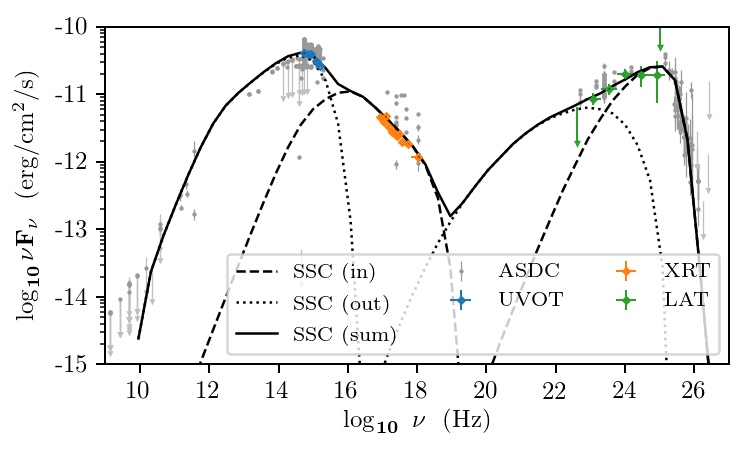

In [17]:
plt.xscale('log')
plt.yscale('log')


########### archival

archival = np.loadtxt('archival.csv')
archival_points = archival[:,3]>0
archival_uls    = archival[:,3]==0
err_pos = \
    10**(archival[:,2][~archival_uls]+archival[:,3][~archival_uls])-\
    10**(archival[:,2][~archival_uls])
err_neg = \
    -10**(archival[:,2][~archival_uls]-archival[:,3][~archival_uls])+\
    10**(archival[:,2][~archival_uls])    
    
plt.errorbar(\
    x = 10**archival[:,0][~archival_uls],\
    y = 10**archival[:,2][~archival_uls],\
    yerr = [err_neg,err_pos],\
    ms=1.5,marker='.',mfc='0.6',alpha=1,mec='0.6',
    ecolor='0.6',ls='',lw=0.5,\
    capsize=0,zorder=-3,label='ASDC')


plt.errorbar(\
    x = 10**archival[:,0][archival_uls],\
    y = 0.3*10**archival[:,2][archival_uls],\
    yerr = [0.0*10**archival[:,2][archival_uls],
            0.7*10**archival[:,2][archival_uls]],
    ms=0.8,marker='v',mfc='0.75',alpha=1,mec='0.75',
    ecolor='0.75',ls='',lw=0.5,\
    capsize=0,zorder=-3,mew=1)


eV2Hz = 4.13566553853599E-15

mwl_data = ascii.read('MW_Data.csv',\
    Reader=ascii.sextractor.SExtractor,delimiter=' ')

mwl_data['energy'].convert_unit_to(u.MeV)
mwl_data['energy_edge_lo'].convert_unit_to(u.MeV)
mwl_data['energy_edge_hi'].convert_unit_to(u.MeV)

data = {}
data['E']  = mwl_data['energy'].to('eV')/eV2Hz
data['El'] = mwl_data['energy'].to('eV')/eV2Hz-mwl_data['energy_edge_lo'].to('eV')/eV2Hz
data['Eh'] = mwl_data['energy_edge_hi'].to('eV')/eV2Hz-mwl_data['energy'].to('eV')/eV2Hz
data['F']  = mwl_data['flux']
data['eF'] = mwl_data['flux_error']

uls = dict(data)

for k in uls:
    try:
        uls[k] = (uls[k][mwl_data['ul']==1]).value
    except:
        uls[k] = (uls[k][mwl_data['ul']==1])

for k in data:
    try:
        data[k] = (data[k][mwl_data['ul']==0]).value
    except:
        data[k] = (data[k][mwl_data['ul']==0])

#print(data)


optical = (data['E']>5e13)*(data['E']<5e15)
xray    = (data['E']>5e15)*(data['E']<5e18)
fermi   = (data['E']>1e22)*(data['E']<1e26)*(data['El']/data['E'] > 0.2)

plt.errorbar(
    x=data['E'][optical],
    xerr=[data['El'][optical],data['Eh'][optical]],
    y=data['F'][optical],
    yerr=data['eF'][optical],
    label='UVOT',color='C0',
    ls='',marker='D',lw=0.8,ms=1.75,mew=1,mfc='None')

plt.errorbar(
    x=data['E'][xray],
    xerr=[data['El'][xray],data['Eh'][xray]],
    y=data['F'][xray],
    yerr=data['eF'][xray],
    label='XRT',color='C1',
    ls='',marker='D',lw=0.8,ms=1.75,mew=1,mfc='None')

plt.errorbar(
    x=data['E'][fermi],
    xerr=[data['El'][fermi],data['Eh'][fermi]],
    y=data['F'][fermi],
    yerr=data['eF'][fermi],
    label='LAT',color='C2',
    ls='',marker='D',lw=0.8,ms=1.75,mew=1,mfc='None')

fermi   = uls['Eh']/uls['E']>0.5

plt.errorbar(
    x=uls['E'][fermi],
    y=0.3*uls['F'][fermi],
    yerr=[0.0*uls['F'][fermi],0.7*uls['F'][fermi]],
    color='C2',label=None,
    ls='',marker='v',lw=0.8,ms=1.2,mew=1,mfc='None')


plt.plot(model1[:,0],model1[:,6],label='SSC (in)',
         ls='dashed',lw=1,color='black')
plt.plot(model2[:,0],model2[:,6],label='SSC (out)',
         ls='dotted',lw=1,color='black')
plt.plot(model1[:,0],model1[:,6]+model2[:,6],label='SSC (sum)',
         ls='solid',lw=1,color='black')

plt.xlim(1e9,1e27)
plt.ylim(1e-15,1e-10)

plt.yticks(10**np.arange(-15,-9.999,1),
           np.array(np.arange(-15,-9.999,1),dtype=int))

plt.xticks(10**np.arange(10,26.001,2),
           np.array(np.arange(10,26.001,2),dtype=int))
#plt.xticklabels(np.arange(10,26.001,2))
plt.ylabel(r'$\mathbf{\log_{10} \nu F_\nu}\ \ \mathrm{(erg/cm^2/s)}$')
plt.xlabel(r'$\mathbf{\log_{10}\ \nu}\ \ \mathrm{(Hz)}$')
plt.legend(fontsize='small',ncol=3)
plt.savefig("PKS1424_TwoZoneModel.png",bbox_inches='tight')